In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np

### temporal kernel in time domain
$$f(t)=\left(\frac{1}{(N_{L}-1)!}\frac{t^{N_{L}-1}}{\tau_{L}^{N_L}}+\frac{H_S}{\tau_{S}\tau_{L}^{N_{L}}}\sum_{i=0}^{N_{L}-1}{\frac{1}{i!}\frac{t^{i}}{\tau_{M}^{N_{L}-i}}}\right)e^{-t/\tau_{L}} - \frac{H_{S}}{\tau_{S}}\frac{1}{\left(\tau_{L}\tau_{M}\right)^{N_{L}}}e^{-t/\tau_{S}}$$

In [3]:
np.seterr(over='raise')
def temporalKernel(A, HS, tauS, NL, tauL, t):
    tauM = tauS*tauL/(tauS-tauL)
    B = HS/tauS*(tauM/tauL)**NL
    sums = np.zeros(t.shape)
    for i in range(NL):
        sums = sums + np.power(t,i)/np.math.factorial(i)/tauM**i
    sums = sums*B
    #sums = 0
    Kt = A*((t**(NL-1)/np.math.factorial(NL-1)/tauL**NL + sums) * np.exp(-t/tauL) - B*np.exp(-t/tauS))
    return Kt

def temporalSimple(A, ratio, tauR, tauD, nR, nD, t):
    Kt = A *( ratio*(t/tauR)**(nR-1)/tauR/np.math.factorial(nR-1)*np.exp(-t/tauR) - (t/tauD)**(nD-1)/tauD/np.math.factorial(nD-1)*np.exp(-t/tauD))
    return Kt

def tKFourier(A, HS, tauS, NL, tauL, D, w):
    Ft = A*np.exp(-1j*w*D)*(1-HS/(1+1j*w*tauS))/(1+1j*w*tauL)**NL
    return Ft

def spatialKernel(kc, ks, rc, rs, x, y):
    Ks = kc*np.exp(-((x-xc)/rc)**2) + ks*np.exp(-((x-xs)/rs)**2)
    return Ks

def sKFourier(k, r, v):
    Fs = kc*rc*np.exp(-(np.pi*rc*v)**2)
    return Fs

In [10]:
t = np.arange(1000)/1000*200
A = 184.2
HS = 0.69
tauS = 18.61
NL = 38
tauL = 1.23
D1 = 4
Kt1 = temporalKernel(A, HS, tauS, NL, tauL, t+D1)

In [11]:
t = np.arange(1000)/1000*200
A = -125.33
HS = 0.56
tauS = 33.28
NL = 124
tauL = 0.42
D2 = 4
Kt2 = temporalKernel(A, HS, tauS, NL, tauL, t+D2)

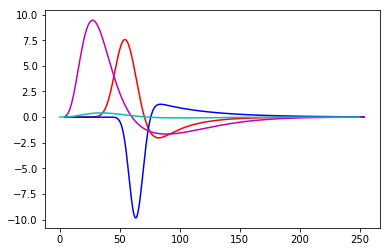

In [21]:
fig = plt.figure('temporal')
ax = fig.add_subplot(111)
ax.plot(t+D1,Kt1,'r')
ax.plot(t+D2,Kt2,'b')
Kt = temporalSimple(150, 2.0, 5.5, 14, 6, 7, t+D1)
ax.plot(t+D1,Kt,'m')
Kt = temporalSimple(10, 2.0, 8.0, 14, 6, 7, t+D)
ax.plot(t,Kt,'c')

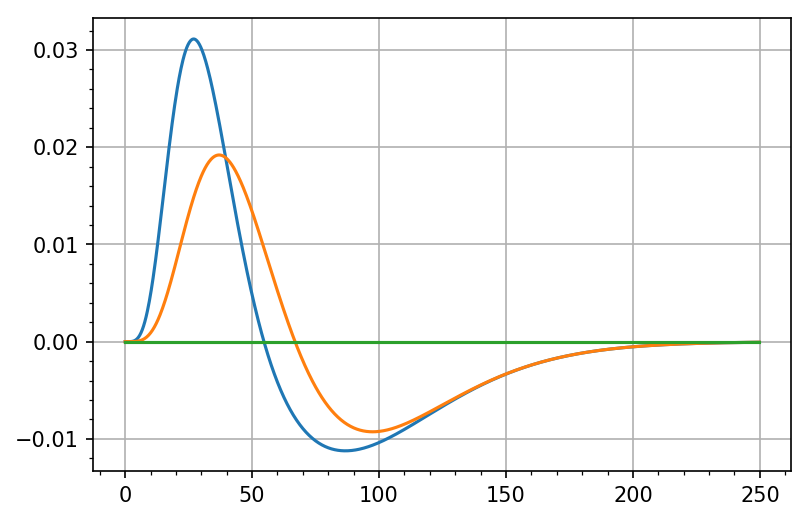

In [13]:
t = np.arange(1000)/1000*250

fig = plt.figure('temporal', dpi = 150)
ax = fig.add_subplot(111)
ax.grid(b=True)
ax.minorticks_on()
for r in range(1,2):
    Kt = temporalSimple(1.0, 1.0, 5.5, 14, 6, 7, t)
    ax.plot(t,Kt)
    Kt = temporalSimple(1.0, 1.0, 8.0, 14, 6, 7, t)
    ax.plot(t,Kt)
    ax.plot(t,np.zeros(t.shape))

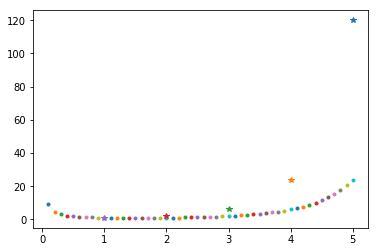

In [68]:
fig = plt.figure('fac')
ax = fig.add_subplot(111)
for i in range(1,51):
    f = i*1.0/10.0
    ax.plot(f,np.math.gamma(f),'.')
ax.plot(5,np.math.factorial(5),'*')
ax.plot(4,np.math.factorial(4),'*')
ax.plot(3,np.math.factorial(3),'*')
ax.plot(2,np.math.factorial(2),'*')
ax.plot(1,np.math.factorial(1),'*')